In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss
from NCP.metrics import hellinger, kullback_leibler, wasserstein1
from NCP.utils import frnp
import lightning as L
from NCP.nn.callbacks import LitProgressBar

import itertools

from NCP.examples.tools.plot_utils import setup_plots
from NCP.examples.tools.data_gen import gen_bimodal, get_conditional_bimodal_cdf, get_conditional_bimodal_pdf
from NCP.examples.tools.lincde import lincde
setup_plots()

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Generating bimodal data as presented in LinCDE (Gao and Hastie). X are 20 dimensional, but only the first 3 dimensions impact Y. 
- the first dimension gives the mean, 
- the second the modality (bi or uni modal) 
- the third the asymetry.

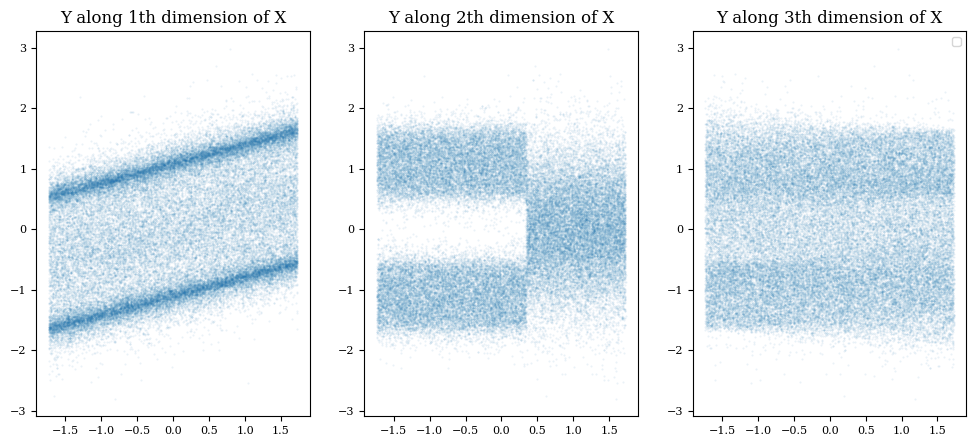

In [7]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_bimodal(0.5, 30, N_train=Ntrain, N_val=Nval, N_test=Ntest)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
axes = ax.flatten()

for i, ax in enumerate(axes):
    ax.scatter(X_train[:,i], Y_train, alpha=0.1, s=0.2)
    ax.set_title(f'Y along {i+1}th dimension of X')
    if i == 0 :
        plt.legend(['train', 'val', 'test'])
plt.show()

In [11]:
lincde(X_train, Y_train)

d:\Grégoire\Documents\ncp\NCP\examples


FileNotFoundError: [Errno 2] No such file or directory: 'temp/matrix.csv'

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 78.2 K
--------------------------------------
78.2 K    Trainable params
0         Non-trainable params
78.2 K    Total params
0.313     Total estimated model params size (MB)


d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 999: 100% 1/1 [00:00<00:00,  1.78it/s, v_num=1, val_loss=-0.817, train_loss=-0.868]  `Trainer.fit` stopped: `max_epochs=1000` reached.
Epoch 999: 100% 1/1 [00:00<00:00,  1.74it/s, v_num=1, val_loss=-0.817, train_loss=-0.868]


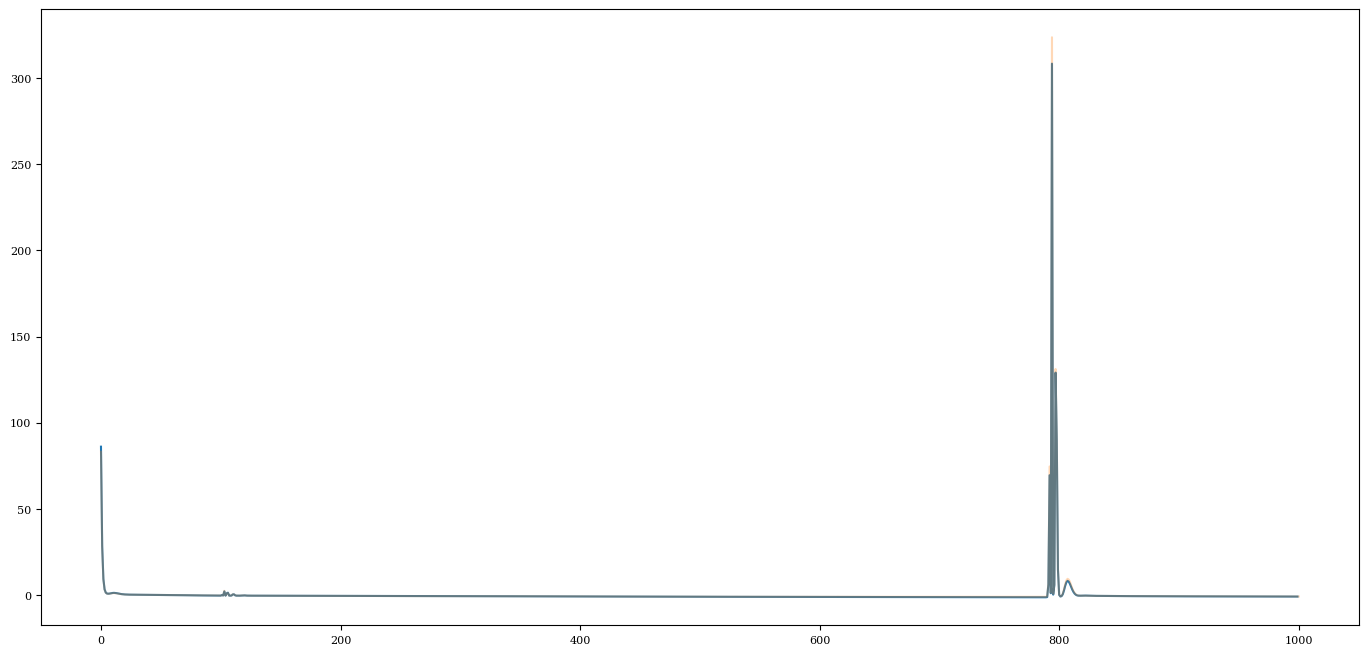

In [11]:
L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)
output_shape = 100

MLP_kwargs_U = {
    'input_shape': X_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 3,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

MLP_kwargs_V = {
    'input_shape': Y_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

result:
- KL: nan
- Hellinger: nan
result:
- KL: nan
- Hellinger: nan


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)
D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)


result:
- KL: nan
- Hellinger: nan
result:
- KL: nan
- Hellinger: nan


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)
D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)


result:
- KL: nan
- Hellinger: nan
result:
- KL: nan
- Hellinger: nan


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)
D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)


result:
- KL: nan
- Hellinger: nan
result:
- KL: nan
- Hellinger: nan


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)
D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)


result:
- KL: nan
- Hellinger: nan


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
D:\Grégoire\Documents\ncp\NCP\metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)


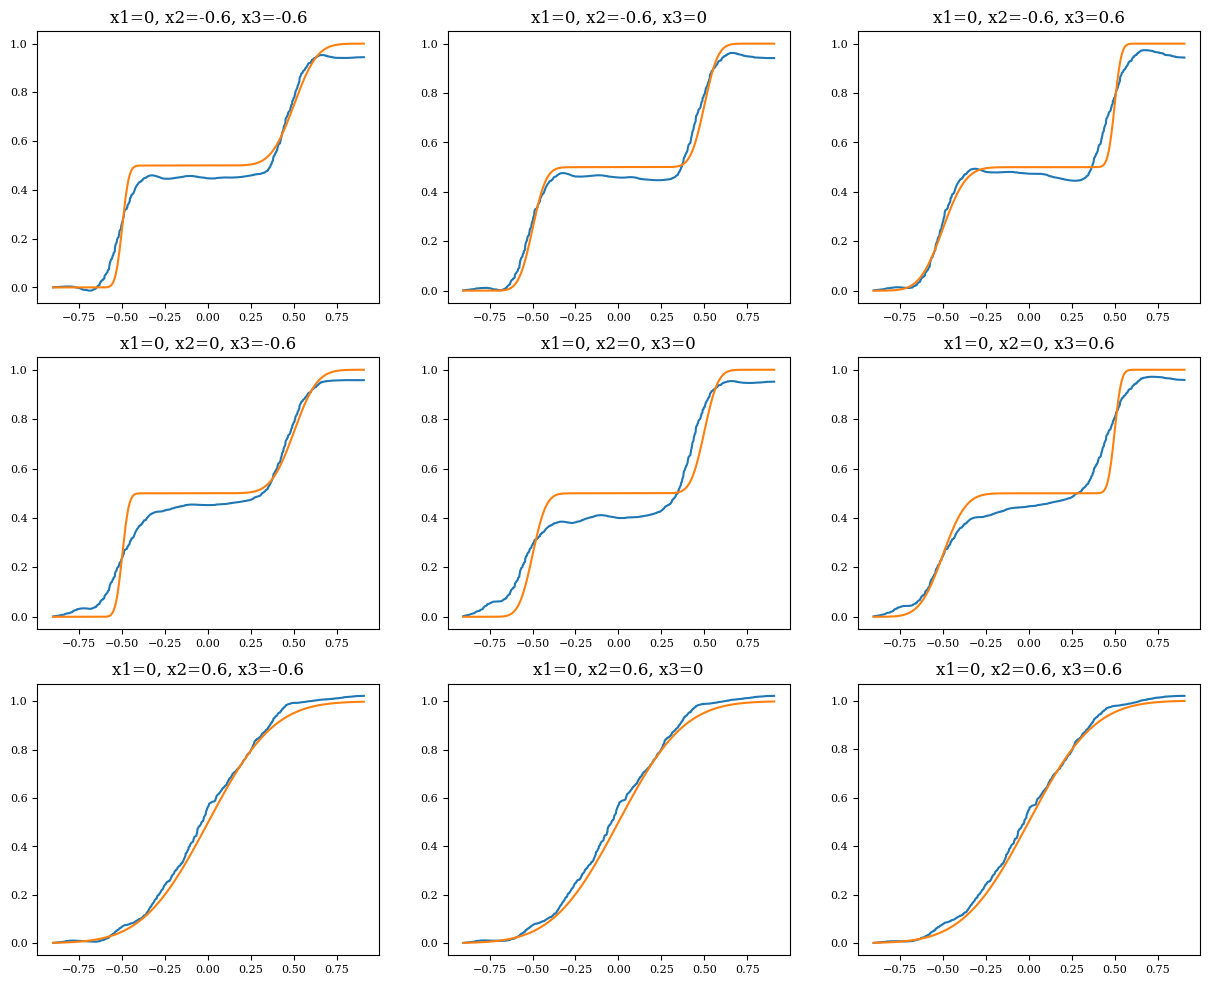

In [42]:
# todo: plot different cdfs, replicate plots from linCDE

x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = torch.Tensor(xscaler.transform([x]))
    fys, cdf_pred = reg.cdf(x_scaled, Y_val_torch, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = get_conditional_bimodal_cdf(x, fys)

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')
    print('result:')
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')

plt.show()

Should we verify that the other dimensions are independent?

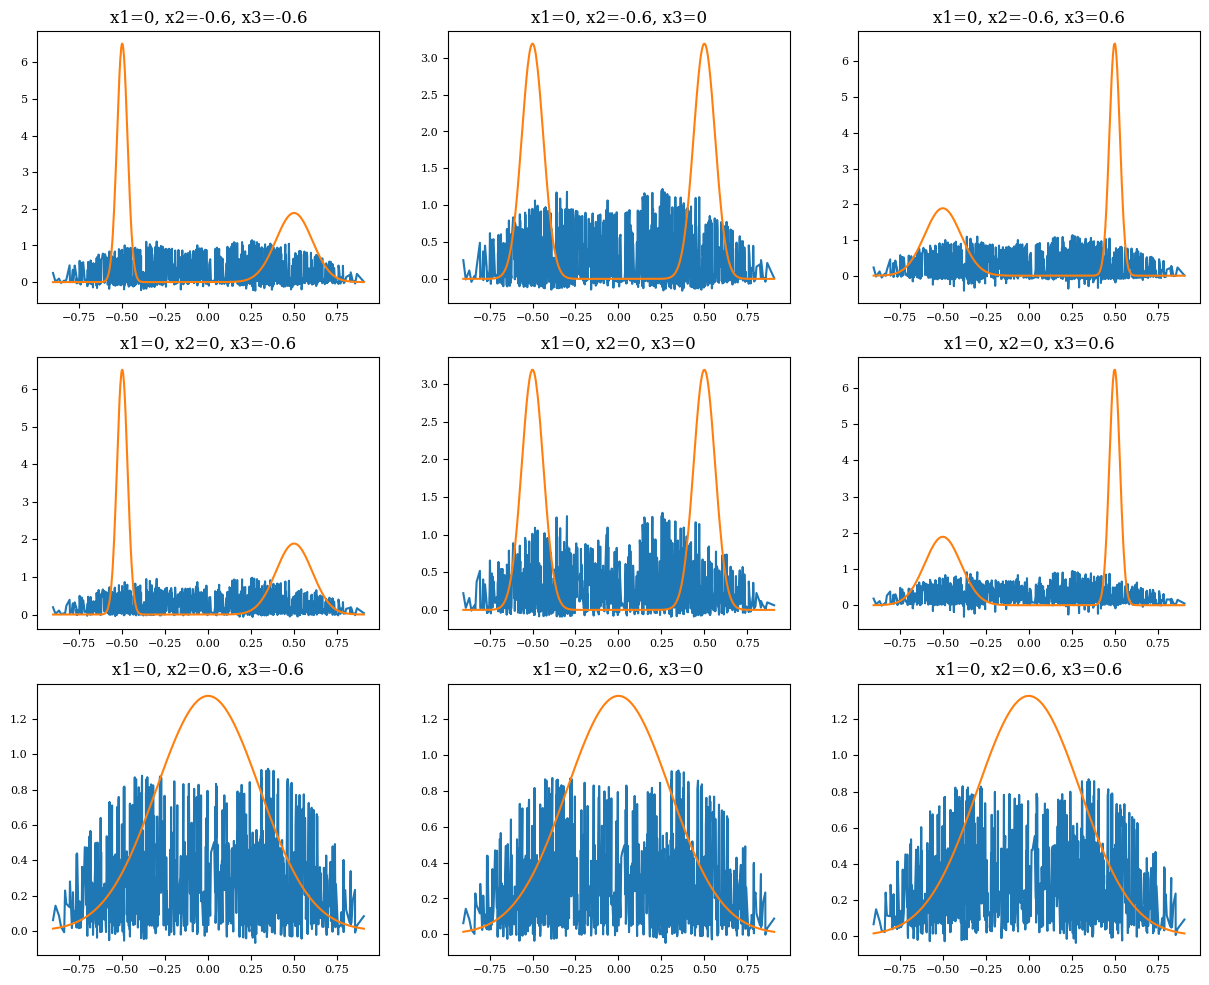

In [45]:
from sklearn.neighbors import KernelDensity
from NCP.utils import tonp

x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

k_pdf = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(Y_val)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = torch.Tensor(xscaler.transform([x]))
    fys, pdf_pred = reg.pdf(x_scaled, Y_val_torch, p_y=marginal, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_pdf = get_conditional_bimodal_pdf(x, fys)

    axes[i].plot(fys, pdf_pred)
    axes[i].plot(fys, true_pdf)
    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.show()